In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
np.random.seed(42)

### Modell:
$Ax=y$

In [3]:
A = np.random.random(size = (100, 100))
x = np.random.random(size = (100, ))

In [4]:
y = np.dot(A, x)

$A$ ist invertierbar:

In [5]:
np.linalg.inv(A)

array([[ 0.58611217,  0.22754722,  0.22079958, ..., -0.35934623,
         0.66178901,  0.19085717],
       [-0.86053578,  0.35823913, -0.05086583, ..., -0.28753986,
         0.01246512, -1.48921599],
       [ 0.26764428, -0.13717687, -0.92694754, ...,  0.09591585,
        -1.22390556,  2.1684163 ],
       ...,
       [ 0.66359634, -0.39434052,  0.53305901, ...,  0.12365094,
         0.66198343,  0.04954313],
       [-0.06110287,  0.01871632, -0.28590078, ...,  0.03731371,
        -0.48258655,  0.91014539],
       [-1.43651032,  0.47662975, -0.21419412, ..., -0.01676364,
         0.36827009, -2.7539353 ]])

Verlustfunktion: quadratischer Fehler $\Vert y - \hat{y}\Vert^2$

In [6]:
def squared_error(y_true, y_pred):
    return np.sum((y_true - y_pred)**2)

Ableitung der Verlustfunktion nach den predictions $\hat{y}$ ist für ein $\hat{y}_i$: 

$-2(y_i-\hat{y}_i)$

In [7]:
def grad_loss(y_true, y_pred):
    return (-2) * (y_true - y_pred)

Loss, wenn der Mittelwert aller $y_i$ stets als prediction verwendet wird:

In [8]:
squared_error(y, np.mean(y))

222.12952243689784

### EnKF-Algorithmus, wie ich ihn auch sonst implementiert habe

In [9]:
iterations = 50
particles = 100
randomization = False

In [10]:
h_0 = 2
epsilon = 0.5

In [11]:
# Dictionary, in das die Partikel (Vektoren, Schätzungen für x) geschrieben werden
param_dict = {}
# Dictionary, in das für alle Partikel die predictions für y geschrieben werden
y_pred_dict = {}
# Dictionary, in das für alle Partikel die Ableitungen der Verlustfunktion nach den predictions geschrieben werden
jacobian_dict = {}
# Dictionary, das für alle Partikel die Werte der Verlustfunktion enthält
loss_dict = {}

Initialisierung durch eine Normalverteilung und erste Auswertung:

In [12]:
for i in range(particles):
    param_dict["particle_{}".format(i+1)] = np.random.normal(loc = 0, scale = 1, size = x.shape)
    y_pred_dict["particle_{}".format(i+1)] = np.dot(A, param_dict["particle_{}".format(i+1)])
    jacobian_dict["particle_{}".format(i+1)] = grad_loss(y, y_pred_dict["particle_{}".format(i+1)])
    loss_dict["particle_{}".format(i+1)] = squared_error(y, y_pred_dict["particle_{}".format(i+1)])

Mittelwerte aller Parameter der Partikel für die endgültige Schätzung von x:

In [13]:
param_mean = np.mean(list(param_dict.values()), axis = 0)

Loss für die gemittelten Parameter fortlaufend notieren:

In [14]:
loss_evolution = []
loss_evolution.append(squared_error(y, np.dot(A, param_mean)))

#### EnKF

In [15]:
for iteration in range(iterations):
    
    # update the predictions, jacobian and loss for the new parameters
    for i in range(particles):
        y_pred_dict["particle_{}".format(i+1)] = np.dot(A, param_dict["particle_{}".format(i+1)])
        jacobian_dict["particle_{}".format(i+1)] = grad_loss(y, y_pred_dict["particle_{}".format(i+1)])
        loss_dict["particle_{}".format(i+1)] = squared_error(y, y_pred_dict["particle_{}".format(i+1)])
    
    # compute the mean of the predictions
    y_pred_mean = np.mean(list(y_pred_dict.values()), axis = 0)
    
    # compute the matrix D elementwise
    d = np.zeros(shape = (particles, particles))
    for k in range(particles):
        y_pred_centered = y_pred_dict["particle_{}".format(str(k+1))] - y_pred_mean
        for j in range(particles):
            d[k][j] = np.dot(y_pred_centered, jacobian_dict["particle_{}".format(str(j+1))])
            
    # compute the scalar h_t
    h_t = h_0 / (np.sqrt(np.sum(d**2)) + epsilon)
        
    # matrix with particle parameters as row vectors
    params_all_ptcls = np.array(list(param_dict.values()))
    
    # compute the matrix with the updates for each particle
    params_all_ptcls = params_all_ptcls - h_t * np.dot(d, params_all_ptcls)
    
    # write the updates back into the dictionary
    for i in range(particles):
        param_dict["particle_{}".format(str(i+1))] = params_all_ptcls[i]
    
    # compute loss for the parameter means
    param_mean = np.mean(list(param_dict.values()), axis = 0)
    loss_evolution.append(squared_error(y, np.dot(A, param_mean)))

In [16]:
h_t

1.1690143171391284e-06

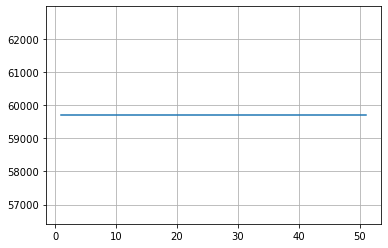

In [17]:
plt.plot(np.arange(len(loss_evolution))+1, loss_evolution)
plt.grid()
plt.show()